In [10]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from env import user, password, host
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import os
import csv
import wrangle_zillow
import prepare
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures

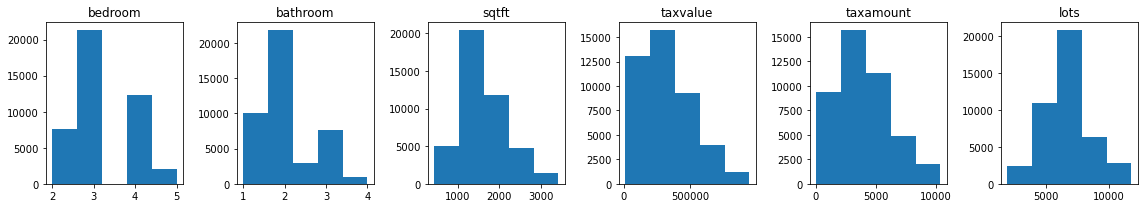

In [2]:
# load zillow data
zillow_train,zillow_validate,zillow_test=wrangle_zillow.wrangle_zillow(1.5)

In [3]:
zillow_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24257 entries, 9653 to 47564
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom          24257 non-null  float64
 1   bathroom         24257 non-null  float64
 2   sqtft            24257 non-null  float64
 3   taxvalue         24257 non-null  float64
 4   yearbuilt        24249 non-null  object 
 5   taxamount        24257 non-null  float64
 6   fips             24257 non-null  object 
 7   lots             24257 non-null  float64
 8   zipcode          24247 non-null  object 
 9   assessmentyear   24257 non-null  object 
 10  transactiondate  24257 non-null  object 
 11  taxrate          24257 non-null  object 
dtypes: float64(6), object(6)
memory usage: 2.4+ MB


In [4]:
zillow_train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom,24257.0,3.198829,0.778007,2.00,3.00,3.00,4.00,5.00
bathroom,24257.0,2.022055,0.697943,1.00,2.00,2.00,2.50,4.00
sqtft,24257.0,1615.423754,541.864106,440.00,1217.00,1517.00,1928.00,3424.00
taxvalue,24257.0,320354.428825,195587.427420,9762.00,168395.00,290868.00,442170.00,947794.00
taxamount,24257.0,3975.308821,2198.399383,49.18,2310.44,3675.27,5362.48,10396.68
lots,24257.0,6647.333223,1796.088127,1890.00,5507.00,6476.00,7577.00,11823.00


In [5]:
# the target will be taxamount

In [15]:
x_train, y_train = zillow_train.select_dtypes('float').drop(columns='taxamount'),zillow_train.taxamount
x_validate, y_validate = zillow_validate.select_dtypes('float').drop(columns='taxamount'),zillow_validate.taxamount
x_train, y_train = zillow_test.select_dtypes('float').drop(columns='taxamount'),zillow_test.taxamount

In [16]:
x_train

,bedroom,bathroom,sqtft,taxvalue,lots
38617,4.0,1.0,1184.0,229113.0,7250.0
3292,3.0,2.0,1828.0,206998.0,7763.0
487,2.0,1.0,836.0,233758.0,5999.0
52187,4.0,2.0,1748.0,140550.0,8588.0
9147,2.0,1.0,935.0,747085.0,7770.0
...,...,...,...,...,...
48344,3.0,2.0,1680.0,97086.0,7484.0
11810,3.0,2.0,1412.0,95240.0,5000.0
4353,2.0,1.0,1121.0,612522.0,6998.0
36081,4.0,2.0,2051.0,209000.0,6792.0


In [23]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# predict mean
y_train['taxamount_avg'] = y_train['taxamount'].mean()
y_validate['taxamount_avg'] = y_validate['taxamount'].mean()

# predict median
y_train['taxamount_med'] = y_train['taxamount'].median()
y_validate['taxamount_med'] = y_validate['taxamount'].median()

# RMSE of mean
rmse_train = mean_squared_error(y_train.taxamount, y_train.taxamount_avg)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxamount, y_validate.taxamount_avg)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# RMSE of median
rmse_train = mean_squared_error(y_train.taxamount, y_train.taxamount_med)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxamount, y_validate.taxamount_med)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))



RMSE using Mean
Train/In-Sample:  2181.59 
Validate/Out-of-Sample:  2211.05
RMSE using Median
Train/In-Sample:  2202.84 
Validate/Out-of-Sample:  2233.27


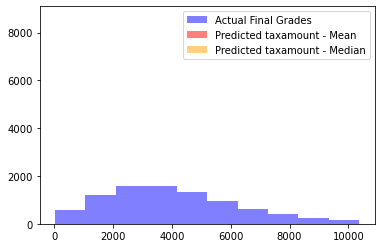

In [32]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.taxamount, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_train.taxamount_avg, bins=1, color='red', alpha=.5, rwidth=10, label="Predicted taxamount - Mean")
plt.hist(y_train.taxamount_med, bins=1, color='orange', alpha=.5, rwidth=10, label="Predicted taxamount - Median")
plt.legend()
plt.show()